# Introduction


This project consists of finding a correlation between job descriptions and skills.

We will focus on the following jobs: Data Scientist- Mobile Developer- Account Manager- CTO- CEO

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/job_description_dataset.csv


# Read data
The following data was created manually.

I searched for the job titles (CEO, Data scientist etc) needed for this exercise on different websites such as LinkedIn and Indeed. And I parsed the whole job description as it in a csv file.

Let's start by reading this data.

In [2]:
test = pd.read_csv('/kaggle/input/job_description_dataset.csv')
## Delete empty rows (In case I missed parsing a row)
test = test.dropna()
print("\n ** raw data **\n")
print(test.head())
print("\n ** data shape **\n")
print(test.shape)


 ** raw data **

        job_title                                        description
0  Data Scientist  We are looking for Freelance Data Scientists t...
1  Data Scientist  It wasn’t so long ago that booking a trip so s...
2  Data Scientist  Are you a Data  Scientist or a Data Engineer w...
3  Data Scientist  Talos Digital is looking for a Data Scientist ...
4  Data Scientist  Job Purpose\n\nAs a Data Scientist in the Roch...

 ** data shape **

(149, 2)


This data contains 149 job descriptions and is structured into two columns: 

* job_title : for the job title.
* description : raw text describing the job requirements.

Let's now check if our data is balanced and therefore eligible to modeling.

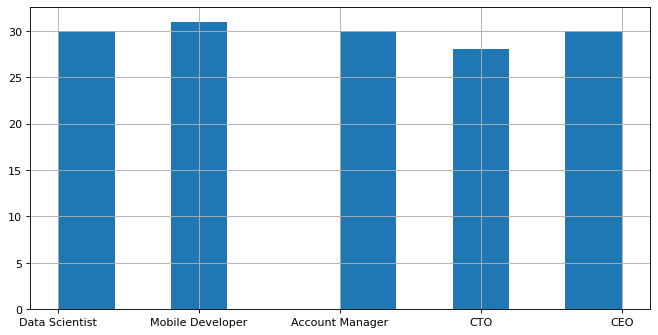

In [3]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
test.job_title.hist()

There are approximatively 30 rows for each job.

**Our data is balanced** so let's move on to preprocessing it.

# Preprocess text data
Since the data we're now working with is at its rawest form, we need to preprocess it before extracting information from it.

in this step, we will:
* Convert all text to lower cases
* Delete all tabulation,spaces, and new lines
* Delete all numericals
* Delete nltk's defined stop words 
* Lemmatize text

In [4]:
## Lower case
test['description'] = test['description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['description'] = test['description'].str.replace('[^\w\s]',' ')
## digits
test['description'] = test['description'].str.replace('\d+', '')

#remove stop words
stop = stopwords.words('english')
test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
test['description'] = test['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(test.head())

Preprocessed data: 

        job_title                                        description
0  Data Scientist  looking freelance data scientist join several ...
1  Data Scientist  long ago booking trip see eiffel tower stroll ...
2  Data Scientist  data scientist data engineer seeking challengi...
3  Data Scientist  talos digital looking data scientist help u di...
4  Data Scientist  job purpose data scientist roche diabetes care...


# Visualize data
In this step, **we will aggregate our data by job titles** in order to visualy detect the most frequent words for each job.

In [5]:
## jda stands for job description aggregated
jda = test.groupby(['job_title']).sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

Aggregated job descriptions: 

          job_title                                        description
0   Account Manager  responsibility lead communication customer off...
1               CEO  role hospital chief executive officer ceo affo...
2               CTO  summary description reporting chief executive ...
3    Data Scientist  looking freelance data scientist join several ...
4  Mobile Developer  zerology looking mobile developer support mobi...



*** Account Manager ***



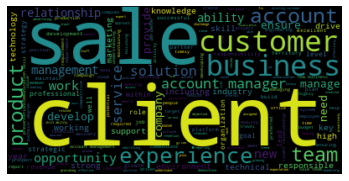


*** CEO ***



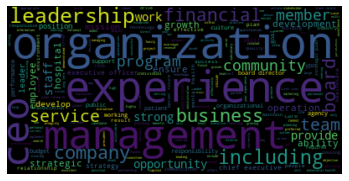


*** CTO ***



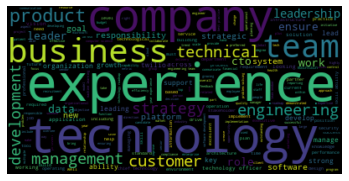


*** Data Scientist ***



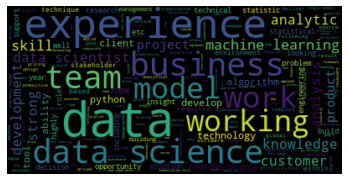


*** Mobile Developer ***



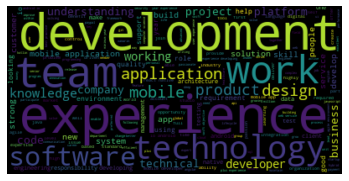

In [6]:
## Visualize data
jobs_list = jda.job_title.unique().tolist()
for job in jobs_list:

    # Start with one review:
    text = jda[jda.job_title == job].iloc[0].description
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

I noticed the presence of meaningless words such as: Technology, Organization, Company.
As well as the presence of the job title itself.

We can safely delete these words from our data.

In [7]:
## Delete more stop words
other_stop_words = ['junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','skill','skills','language','menu','inc','new','plus','years',
                   'technology','organization','ceo','cto','account','manager','data','scientist','mobile',
                    'developer','product','revenue','strong']

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

# Modeling
We are now going to translate this skill-extraction problem into a classification one first.
And then extract the most important features from each class.

The most important features, in this case, represent the words that most likely will belong to a class ( in our case job title) 


I chose for this exercise to train the naive bayes algorithm.

In [8]:
## Converting text to features 
vectorizer = TfidfVectorizer()
#Tokenize and build vocabulary
X = vectorizer.fit_transform(test.description)
y = test.job_title

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) 
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

train data shape:  (119, 4547)
test data shape:  (30, 4547)


Let's do a quick sanity check for the distribution of our train and test data.

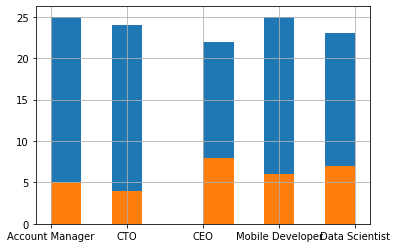

In [9]:
y_train.hist()
y_test.hist()

## MODEL EVALUATION 

In [10]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.8
Classes: (to help read Confusion Matrix)
 ['Account Manager' 'CEO' 'CTO' 'Data Scientist' 'Mobile Developer']
Confusion Matrix: 
[[5 0 0 0 0]
 [0 5 3 0 0]
 [0 0 2 1 1]
 [0 0 0 6 1]
 [0 0 0 0 6]]
Classification Report: 
                  precision    recall  f1-score   support

 Account Manager       1.00      1.00      1.00         5
             CEO       1.00      0.62      0.77         8
             CTO       0.40      0.50      0.44         4
  Data Scientist       0.86      0.86      0.86         7
Mobile Developer       0.75      1.00      0.86         6

        accuracy                           0.80        30
       macro avg       0.80      0.80      0.79        30
    weighted avg       0.84      0.80      0.80        30



# Model evaluation and interpretation
**Our accuracy score is 80% which is acceptable.**

*NOTE:* Model accuracy dropped down after deleting the job titles from their respective descriptions. Which is expectable. ( If most job descriptions for CEO contain the word CEO, then the token CEO will be the most important feature for the class CEO)

This way our model will give more weight to other remaining/meaningful tokens 

The confusion matrix shows that the features for the account manager, data scientist and mobile developer are differenciable. Therefore, we expect to extract meaningful features out of these classes.

Meanwhile, 3 out of 8 CEO classes were classified as CTO. So there is a little confusion between CTO and CEO.
And 2 out of 4 CTO classes were classified as Data Scientist and Mobile developer. I think this is due to the fact that in training data there was less CTO data than the rest.



# Feature extraction
Let's now extract the most meaningful features of each class.

To do so, we can access the attribute *feature_log_prob_* from our model which returns the log probability of features given a class.

We will next sort the log probabilies descendingly.

And finally map the most important tokens to the classes


In [11]:
print(clf.coef_)
print(clf.coef_.shape)

[[-8.43062501 -7.80019193 -8.28422135 ... -8.4772855  -8.4772855
  -8.4772855 ]
 [-8.47205413 -7.98334489 -8.40416058 ... -8.40912003 -8.44009208
  -8.44009208]
 [-8.47827676 -7.75321972 -8.14619705 ... -8.47827676 -8.47827676
  -8.47827676]
 [-8.4724407  -8.00421077 -8.24392093 ... -8.4724407  -8.4724407
  -8.4724407 ]
 [-8.47631345 -8.26123509 -8.1429054  ... -8.47631345 -8.47631345
  -8.47631345]]
(5, 4547)


# Output
At this step, we have for each class/job a list of the most representative words/tokens found in job descriptions.

Let's shrink this list of words to only:
* 6 technical skills
* 6 adjectives

To do so, we use the library *TextBlob* to identify adjectives.

Also, given a (non-exhaustive) list of programming languages, we can extract the top technical skills.


In [12]:
from textblob import TextBlob
technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn',
                    'numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow',
                   'linux','Ruby','JavaScript','django','react','reactjs','ai','ui','tableau']
feature_array = vectorizer.get_feature_names()
# number of overall model features
features_numbers = len(feature_array)
## max sorted features number
n_max = int(features_numbers * 0.1)

##initialize output dataframe
output = pd.DataFrame()
for i in range(0,len(clf.classes_)):
    print("\n****" ,clf.classes_[i],"****\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(raw_skills)
    
    ## Extract technical skills
    top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:6]
    #print("Top technical skills",top_technical_skills)
    
    ## Extract adjectives
    
    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    #raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    #raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:6]
    #print("Top 6 adjectives: ",top_adjectives)
    
    output = output.append({'job_title':clf.classes_[i],
                        'technical_skills':top_technical_skills,
                        'soft_skills':top_adjectives },
                       ignore_index=True)


**** Account Manager ****

list of unprocessed skills :
['client' 'sale' 'customer' 'business' 'relationship' 'solution' 'team'
 'management' 'service' 'need' 'ability' 'ensure' 'opportunity'
 'territory' 'marketing' 'provide' 'manage' 'satisfaction' 'campaign'
 'assigned' 'existing' 'develop' 'responsible' 'technical' 'siren'
 'including' 'support' 'drive' 'industry' 'key' 'grow' 'kaseya' 'project'
 'within' 'fis' 'production' 'communication' 'altair' 'environment' 'year'
 'goal' 'semiconductor' 'selling' 'partner' 'google' 'well' 'presentation'
 'successful' 'working' 'portfolio' 'strategic' 'growth' 'timely'
 'manages' 'identify' 'area' 'ad' 'professional' 'high' 'platform' 'plan'
 'role' 'activity' 'strategy' 'delivery' 'meet' 'level' 'lead' 'meeting'
 'safety' 'advertising' 'arcesium' 'preferred' 'maintain' 'internal'
 'contact' 'target' 'excel' 'proactively' 'knowledge' 'build' 'employee'
 'excellent' 'understanding' 'degree' 'fast' 'responsibility' 'success'
 'complex' 'departm

Correlation between jobs and skills:

In [13]:
print(output.T)

                                                                  0  \
job_title                                           Account Manager   
soft_skills       [responsible, technical, key, grow, fis, succe...   
technical_skills                                                 []   

                                                                  1  \
job_title                                                       CEO   
soft_skills       [strategic, financial, mental, arbor, high, ch...   
technical_skills                                                 []   

                                                                  2  \
job_title                                                       CTO   
soft_skills       [technical, technological, chief, strategic, r...   
technical_skills                                                 []   

                                                                  3  \
job_title                                            Data Scientist   
sof

# Conclusion

We reached acceptable accuracy with the basic model Naive Bayes.

This solution can be improved by:
* adding a larger dataset and thus a larger training data for naive bayes algorithm
* Extracting more accurate adjectives: library TextBlob that we used for this exercice has some inaccuracies when extracting adjectives. For example, it faulty considered the terms "app", "web" "test" as adjectives.
* Experimenting with other models for better model accuracy score
* Using bi-grams tokens and not only uni-grams ones. 
* Using technologies such as pyspark to make the data manipulation pipeline more scalable
* Adding an exhaustive list of technologies